In [302]:
from pyspark.sql.functions import *
import pyspark as ps
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
import numpy as np

In [190]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df capstone") \
            .getOrCreate()

dframe = spark.read.json('./data/mpd.slice.0-999.json', multiLine=True)

In [191]:
sc = spark.sparkContext

In [192]:
dframe.printSchema()


root
 |-- info: struct (nullable = true)
 |    |-- generated_on: string (nullable = true)
 |    |-- slice: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- playlists: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- collaborative: string (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- duration_ms: long (nullable = true)
 |    |    |-- modified_at: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- num_albums: long (nullable = true)
 |    |    |-- num_artists: long (nullable = true)
 |    |    |-- num_edits: long (nullable = true)
 |    |    |-- num_followers: long (nullable = true)
 |    |    |-- num_tracks: long (nullable = true)
 |    |    |-- pid: long (nullable = true)
 |    |    |-- tracks: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- album_name: string (nullable = true)
 |    |    |    |

In [196]:
dframe.show()

+--------------------+--------------------+
|                info|           playlists|
+--------------------+--------------------+
|[2017-12-03 08:41...|[[false,, 1153241...|
+--------------------+--------------------+



In [197]:
dframe.createOrReplaceTempView('play_frame')

In [198]:
preview = spark.sql('''
                    SELECT playlists
                    FROM play_frame
''')

In [199]:
preview.show()

+--------------------+
|           playlists|
+--------------------+
|[[false,, 1153241...|
+--------------------+



In [200]:
type(preview)

pyspark.sql.dataframe.DataFrame

In [202]:
playlist = dframe.head()[1]

In [204]:
type(playlist), len(playlist)

(list, 1000)

In [205]:
len(playlist[0])

12

In [206]:
single_playlist = playlist[0]

In [208]:
for element in single_playlist: 
    print (type(element), element, '\n')

<class 'str'> false 

<class 'NoneType'> None 

<class 'int'> 11532414 

<class 'int'> 1493424000 

<class 'str'> Throwbacks 

<class 'int'> 47 

<class 'int'> 37 

<class 'int'> 6 

<class 'int'> 1 

<class 'int'> 52 

<class 'int'> 0 

<class 'list'> [Row(album_name='The Cookbook', album_uri='spotify:album:6vV5UrXcfyQD1wu4Qo2I9K', artist_name='Missy Elliott', artist_uri='spotify:artist:2wIVse2owClT7go1WT98tk', duration_ms=226863, pos=0, track_name='Lose Control (feat. Ciara & Fat Man Scoop)', track_uri='spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'), Row(album_name='In The Zone', album_uri='spotify:album:0z7pVBGOD7HCIB7S8eLkLI', artist_name='Britney Spears', artist_uri='spotify:artist:26dSoYclwsYLMAKD3tpOr4', duration_ms=198800, pos=1, track_name='Toxic', track_uri='spotify:track:6I9VzXrHxO9rA9A5euc8Ak'), Row(album_name='Dangerously In Love (Alben für die Ewigkeit)', album_uri='spotify:album:25hVFAxTlDvXbx2X2QkUkE', artist_name='Beyoncé', artist_uri='spotify:artist:6vWDO969PvNqNYHIOW5v0m', d

In [209]:
single_tracklist = single_entry[11]

In [210]:
len(single_tracklist)

52

In [244]:
single_track = single_tracklist[0].asDict()
single_track

{'album_name': 'The Cookbook',
 'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
 'artist_name': 'Missy Elliott',
 'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk',
 'duration_ms': 226863,
 'pos': 0,
 'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)',
 'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'}

In [213]:
single_playlist.asDict()

{'collaborative': 'false',
 'description': None,
 'duration_ms': 11532414,
 'modified_at': 1493424000,
 'name': 'Throwbacks',
 'num_albums': 47,
 'num_artists': 37,
 'num_edits': 6,
 'num_followers': 1,
 'num_tracks': 52,
 'pid': 0,
 'tracks': [Row(album_name='The Cookbook', album_uri='spotify:album:6vV5UrXcfyQD1wu4Qo2I9K', artist_name='Missy Elliott', artist_uri='spotify:artist:2wIVse2owClT7go1WT98tk', duration_ms=226863, pos=0, track_name='Lose Control (feat. Ciara & Fat Man Scoop)', track_uri='spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'),
  Row(album_name='In The Zone', album_uri='spotify:album:0z7pVBGOD7HCIB7S8eLkLI', artist_name='Britney Spears', artist_uri='spotify:artist:26dSoYclwsYLMAKD3tpOr4', duration_ms=198800, pos=1, track_name='Toxic', track_uri='spotify:track:6I9VzXrHxO9rA9A5euc8Ak'),
  Row(album_name='Dangerously In Love (Alben für die Ewigkeit)', album_uri='spotify:album:25hVFAxTlDvXbx2X2QkUkE', artist_name='Beyoncé', artist_uri='spotify:artist:6vWDO969PvNqNYHIOW5v0m', durati

In [252]:
column_names = single_playlist.__fields__
column_names

['collaborative',
 'description',
 'duration_ms',
 'modified_at',
 'name',
 'num_albums',
 'num_artists',
 'num_edits',
 'num_followers',
 'num_tracks',
 'pid',
 'tracks']

In [253]:
pframe = pd.DataFrame(playlist, columns = column_names)

In [256]:
pframe

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,tracks
0,false,None,11532414,1493424000,Throwbacks,47,37,6,1,52,0,"[(The Cookbook, spotify:album:6vV5UrXcfyQD1wu4..."
1,false,None,11656470,1506556800,Awesome Playlist,23,21,5,1,39,1,"[(Eye Of The Tiger, spotify:album:4PT9VulQaQP6..."
2,false,None,14039958,1505692800,korean,51,31,18,1,64,2,"[(On And On, spotify:album:7hq1c0ZrLiSKxzhoRac..."
3,false,None,28926058,1501027200,mat,107,86,4,1,126,3,"[(French Festival, spotify:album:0T9YCy8TruLD6..."
4,false,None,4335282,1401667200,90s,16,16,7,2,17,4,"[(Mellon Collie and the Infinite Sadness, spot..."
...,...,...,...,...,...,...,...,...,...,...,...,...
995,false,None,9917901,1507852800,old,40,36,8,1,41,995,"[(Walkin' On Sunshine (Re-Recorded Versions), ..."
996,false,None,3699248,1479254400,Daze,17,15,13,1,17,996,"[(PARTYNEXTDOOR 3 (P3), spotify:album:2FXGUAES..."
997,false,None,27538723,1410307200,rap,98,82,63,1,119,997,"[(UP!, spotify:album:4I8VoaNOYQn92D8ejMPGlw, L..."
998,false,None,24950143,1507939200,Country,75,40,37,1,108,998,"[(Hunter Hayes (Encore), spotify:album:5hVo5O3..."


In [268]:
cleaned_frame = pframe.drop('tracks', axis=1).copy()
cleaned_frame.drop('name', axis=1, inplace=True)
cleaned_frame.drop('description', axis=1, inplace=True)
cleaned_frame.drop('modified_at', axis=1, inplace=True)

In [269]:
cleaned_frame

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,pid
0,false,11532414,47,37,6,1,52,0
1,false,11656470,23,21,5,1,39,1
2,false,14039958,51,31,18,1,64,2
3,false,28926058,107,86,4,1,126,3
4,false,4335282,16,16,7,2,17,4
...,...,...,...,...,...,...,...,...
995,false,9917901,40,36,8,1,41,995
996,false,3699248,17,15,13,1,17,996
997,false,27538723,98,82,63,1,119,997
998,false,24950143,75,40,37,1,108,998


In [271]:
# COLUMNS OF INTEREST ISOLATED INTO CLEAN FRAME IN 'df' VARIABLE:
df = cleaned_frame

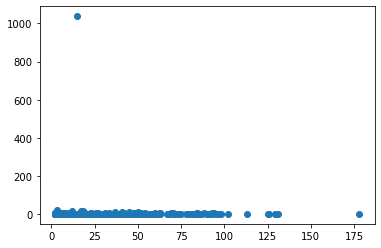

In [273]:
# comparing number of edits to number of followers. Data does not look interesting. 
plt.scatter(df.num_edits, df.num_followers)

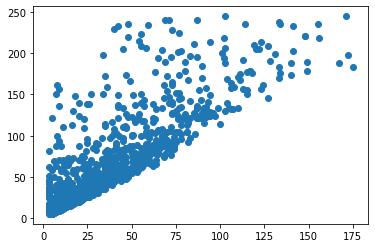

In [277]:
#comparing number of artists to number of tracks (playlist diversity?) - seems interesting, consistent ratio? 
plt.scatter(df.num_artists, df.num_tracks)
#explore plotting the line of completely diverse songs
#entropy of a group: think of a way to score the diversity numerically? (distance from the 1:1 ratio line, or, more simply: ratio of artists to tracks)

(array([287., 235., 157.,  94.,  68.,  54.,  34.,  28.,  24.,  19.]),
 array([  5.,  29.,  53.,  77., 101., 125., 149., 173., 197., 221., 245.]),
 <BarContainer object of 10 artists>)

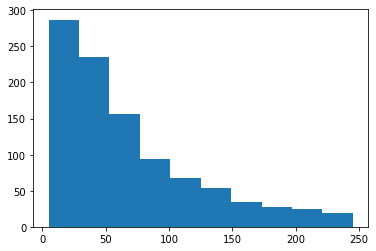

In [278]:
#looking at number of tracks
plt.hist(df.num_tracks)

(array([348., 256., 155.,  97.,  66.,  34.,  20.,  12.,   8.,   4.]),
 array([  3. ,  20.2,  37.4,  54.6,  71.8,  89. , 106.2, 123.4, 140.6,
        157.8, 175. ]),
 <BarContainer object of 10 artists>)

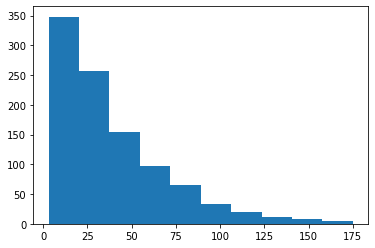

In [279]:
#looking at number of artists per playlist
plt.hist(df.num_artists)

In [280]:
df['diversity_ratio'] = df['num_artists'] / df['num_tracks']

In [281]:
df

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,diversity_ratio
0,false,11532414,47,37,6,1,52,0,0.711538
1,false,11656470,23,21,5,1,39,1,0.538462
2,false,14039958,51,31,18,1,64,2,0.484375
3,false,28926058,107,86,4,1,126,3,0.682540
4,false,4335282,16,16,7,2,17,4,0.941176
...,...,...,...,...,...,...,...,...,...
995,false,9917901,40,36,8,1,41,995,0.878049
996,false,3699248,17,15,13,1,17,996,0.882353
997,false,27538723,98,82,63,1,119,997,0.689076
998,false,24950143,75,40,37,1,108,998,0.370370


(array([ 30.,  36.,  44.,  75., 101., 121., 158., 170., 150., 115.]),
 array([0.03703704, 0.13333333, 0.22962963, 0.32592593, 0.42222222,
        0.51851852, 0.61481481, 0.71111111, 0.80740741, 0.9037037 ,
        1.        ]),
 <BarContainer object of 10 artists>)

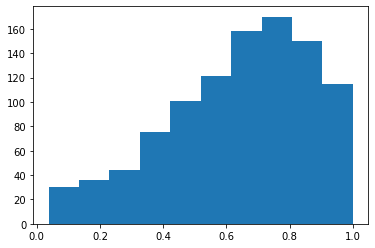

In [282]:
plt.hist(df.diversity_ratio)

In [ ]:
df.corr()

<AxesSubplot:>

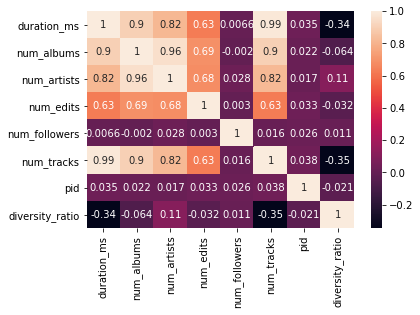

In [286]:
sn.heatmap(df.corr(), annot=True)

## Thoughts on hypothesis: 

- Could test H0 = the average playlist is 50% diverse OR LESS <- for the sample
- HA = the average playlist is more than 50% diverse
- right-tailed test, entire p-value is in right tail
- average from the sample is likely to be the average of the population?? <- separate test using confidence interval (sample vs. population) 
    - bootstrapping, confidence interval
- possible additional test: does diversity_ratio have an effect on follower count? 

In [308]:
sample_mean = df.diversity_ratio.mean()
sample_mean

0.6389526333133356

In [309]:
sample_std = df.diversity_ratio.std()
sample_std

0.2304510407738965

In [333]:
sample_norm = stats.norm(sample_mean, sample_std)
null_norm = stats.norm(0.5, sample_std)

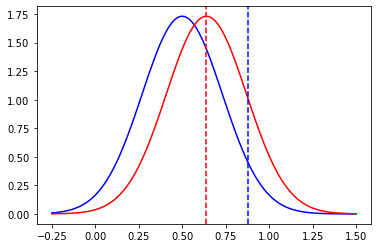

In [372]:
right_tail = null_norm.ppf(.95)

fig, ax = plt.subplots()
x = np.linspace(-0.25,1.5,100)
ax.plot(x, null_norm.pdf(x), color='blue')
ax.plot(x, sample_norm.pdf(x), color='red')
ax.axvline(right_tail, color='blue', linestyle='dashed')
ax.axvline(sample_mean, color='red', linestyle='dashed')


In [316]:
count_over_50 = df[df['diversity_ratio']>.5].count()
count_over_50['diversity_ratio']

733

In [343]:
p_value = null_norm.cdf(sample_mean)
p_value

0.726732168077946

#### With 95% confidence, failed to reject the null hypothesis that playlists are on average less than 50% diverse.

### think about: 
- example hypothesis: playlists with a "high" number of followers have a higher diversity ratio
- can compare the diference between the "high follower" set and the "low follower" set to see if diversity ratio influences follower count
- t-test to see if you can confidently reject the null-hypothesis

In [382]:
less_than = df[df['num_followers'] < 10]

In [383]:
greater_equal = df[df['num_followers'] >= 10]

In [384]:
less_than_mean = less_than.diversity_ratio.mean()
less_than_mean

0.6386820910367528

In [385]:
greater_equal_mean = greater_equal.diversity_ratio.mean()
greater_equal_mean

0.6724998756095926

In [386]:
less_than_std = less_than.diversity_ratio.std()
less_than_std

0.2302076566364094

In [387]:
greater_equal_std = greater_equal.diversity_ratio.std()
greater_equal_std

0.2743546913898894

In [388]:
less_than_norm = stats.norm(less_than_mean, less_than_std)
greater_equal_norm = stats.norm(greater_equal_mean, greater_equal_std)

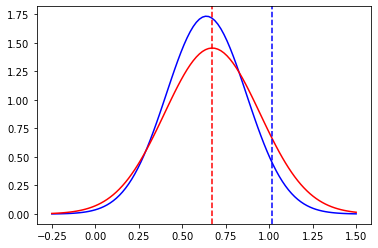

In [389]:
right_tail = less_than_norm.ppf(.95)
right_tail

fig, ax = plt.subplots()
x = np.linspace(-0.25,1.5,100)
ax.plot(x, less_than_norm.pdf(x), color='blue')
ax.plot(x, greater_equal_norm.pdf(x), color='red')
ax.axvline(right_tail, color='blue', linestyle='dashed')
ax.axvline(greater_equal_mean, color='red', linestyle='dashed')